In [ ]:
# from utils.data_build import build_kru_dataframe_and_save

# df = build_kru_dataframe_and_save("/workspace/kru_data", "/workspace/kru_data/data_tag.json", "data_source.csv")

In [ ]:
import pandas as pd 

print("Train 데이터셋 개수", len(pd.read_csv("/workspace/kru_data/train.csv")))
print("Test 데이터셋 개수", len(pd.read_csv("/workspace/kru_data/test.csv")))

Train 데이터셋 개수 1018121


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib import rcParams
from matplotlib.patches import Rectangle

# Nature 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")  # 색맹 친화적 팔레트

# 고해상도 설정 (Nature 권장: 300 DPI)
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300
rcParams['savefig.bbox'] = 'tight'
rcParams['font.size'] = 8
rcParams['axes.labelsize'] = 9
rcParams['axes.titlesize'] = 10
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 7
rcParams['figure.titlesize'] = 11
# 나눔 스퀘어 폰트 설정
rcParams['font.family'] = 'sans-serif'
# 나눔 스퀘어 폰트 우선순위 설정 (여러 변형 시도)
rcParams['font.sans-serif'] = ['NanumSquare', 'NanumSquareOTF', 'NanumSquareNeo', 'NanumGothic', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

# 폰트 확인 및 설정
try:
    from matplotlib import font_manager
    # 사용 가능한 나눔 스퀘어 폰트 찾기
    available_fonts = [f.name for f in font_manager.fontManager.ttflist]
    nanum_fonts = [f for f in available_fonts if 'Nanum' in f and 'Square' in f]
    if nanum_fonts:
        print(f"✓ 나눔 스퀘어 폰트 발견: {nanum_fonts[0]}")
        rcParams['font.sans-serif'] = [nanum_fonts[0]] + rcParams['font.sans-serif']
    else:
        print("⚠ 나눔 스퀘어 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
        print(f"사용 가능한 나눔 폰트: {[f for f in available_fonts if 'Nanum' in f]}")
except Exception as e:
    print(f"폰트 확인 중 오류: {e}")
    print("기본 폰트 설정을 사용합니다.")
rcParams['axes.linewidth'] = 0.5
rcParams['grid.linewidth'] = 0.5
rcParams['lines.linewidth'] = 1.0

# 색상 팔레트 (Nature 스타일, 색맹 친화적)
nature_colors = {
    'blue': '#2E86AB',
    'orange': '#F24236',
    'green': '#6A994E',
    'red': '#BC4749',
    'purple': '#7209B7',
    'yellow': '#F77F00',
    'teal': '#06A77D',
    'pink': '#D62828'
}

# figures 디렉토리 생성
os.makedirs('/workspace/notebook/figures', exist_ok=True)

# data_tag.json 로드
import simdjson as json
with open('/workspace/kru_data/data_tag.json', 'r', encoding='utf-8') as f:
    tag_data = json.loads(f.read())

# 카테고리별 순서 및 설명 추출
category_info = {}
for key, value in tag_data.items():
    col_name = key.strip()
    category_info[col_name] = {
        'description': value.get('description', ''),
        'order': value.get('-index_order', 0),
        'values': value.get('values', {})
    }

# soundfile 모듈 import (빠뜨린 경우 보완)
import soundfile as sf

def wav_length_fast(path):
    info = sf.info(path)
    return info.frames / info.samplerate

from tqdm import tqdm
from multiprocessing import Pool

def wav_length_parallel(path_or_df, num_workers=16):
    # CSV 경로가 들어오면 DataFrame으로 로드
    if isinstance(path_or_df, str):
        df = pd.read_csv(path_or_df)
    elif isinstance(path_or_df, pd.DataFrame):
        df = path_or_df
    else:
        raise ValueError("path_or_df는 str(CSV 경로) 또는 pd.DataFrame이어야 합니다.")

    if "abs_path" not in df.columns:
        raise KeyError("'abs_path' 컬럼이 데이터프레임에 존재하지 않습니다.")
    paths = df["abs_path"].tolist()

    with Pool(num_workers) as p:
        lengths = list(tqdm(p.imap(wav_length_fast, paths), total=len(paths)))

    df["wav_length_sec"] = lengths
    return df

# 실제 코드 실행
all_df = wav_length_parallel("/workspace/kru_data/data_source.csv")
print(f"총 데이터 수: {len(all_df):,}개")
print(f"컬럼 수: {len(all_df.columns)}개")
print("\n카테고리 정보:")
for col, info in category_info.items():
    print(f"  {col}: {info['description']}")

✓ 나눔 스퀘어 폰트 발견: NanumSquareRound


100%|██████████| 1272625/1272625 [00:26<00:00, 48624.41it/s]


총 데이터 수: 1,272,625개
컬럼 수: 7개

카테고리 정보:
  데이터_항목: 데이터 수집 주체 구분
  데이터_카테고리: 데이터 수집 대상 직업군
  성별: 참여자 성별 구분
  연령: 연령대 구분
  지역: 참여자 지역 구분


In [3]:
total_sec = all_df['wav_length_sec'].sum()
print(f"총 오디오 길이: {total_sec:.2f}초")
print(f"총 오디오 길이: {total_sec/60:.2f}분")
print(f"총 오디오 길이: {total_sec/3600:.2f}시간")


총 오디오 길이: 4485099.61초
총 오디오 길이: 74751.66분
총 오디오 길이: 1245.86시간


In [ ]:
# ============================================================================
# Figure 1: Dataset Overview and Demographic Distribution
# Nature-style publication figure (data_tag.json 기반)
# ============================================================================

# data_tag.json의 values 순서대로 정렬
def get_ordered_values(col_name):
    """data_tag.json의 values 순서대로 카테고리 값 반환"""
    if col_name not in category_info:
        return all_df[col_name].value_counts().index.tolist()
    
    values_dict = category_info[col_name]['values']
    # values_dict의 값(value) 순서대로 정렬
    ordered = list(values_dict.values())
    # 실제 데이터에 있는 값만 필터링
    return [v for v in ordered if v in all_df[col_name].values]

# 데이터 준비 (data_tag.json 순서대로 정렬)
카테고리_순서 = get_ordered_values('데이터_카테고리')
카테고리_분포 = all_df['데이터_카테고리'].value_counts().reindex(카테고리_순서)

성별_순서 = get_ordered_values('성별')
성별_분포 = all_df['성별'].value_counts().reindex(성별_순서)

연령_순서 = get_ordered_values('연령')
연령_분포 = all_df['연령'].value_counts().reindex(연령_순서)

지역_순서 = get_ordered_values('지역')
지역_분포 = all_df['지역'].value_counts().reindex(지역_순서)

항목_순서 = get_ordered_values('데이터_항목')
항목_분포 = all_df['데이터_항목'].value_counts().reindex(항목_순서)

# 교차 분석 데이터 (순서 유지)
교차_카테고리_성별 = pd.crosstab(all_df['데이터_카테고리'], all_df['성별'])
교차_카테고리_성별 = 교차_카테고리_성별.reindex(카테고리_순서).reindex(columns=성별_순서)

교차_카테고리_연령 = pd.crosstab(all_df['데이터_카테고리'], all_df['연령'])
교차_카테고리_연령 = 교차_카테고리_연령.reindex(카테고리_순서).reindex(columns=연령_순서)

# Figure 생성 (Nature 스타일: 2열 3행 레이아웃)
fig = plt.figure(figsize=(7.2, 12))  # Nature 권장 너비: 89mm (3.5인치) 또는 183mm (7.2인치)
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3, left=0.1, right=0.95, top=0.95, bottom=0.08)

# A: 데이터_카테고리 분포 (data_tag.json: 데이터 수집 대상 직업군)
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(range(len(카테고리_분포)), 카테고리_분포.values, 
                color=[nature_colors['blue'], nature_colors['orange'], nature_colors['green']],
                edgecolor='black', linewidth=0.5, alpha=0.8)
ax1.set_xticks(range(len(카테고리_분포)))
ax1.set_xticklabels(카테고리_분포.index, rotation=0)
ax1.set_ylabel('Number of samples', fontweight='bold')
ax1.set_title('A. ' + category_info['데이터_카테고리']['description'], fontweight='bold', pad=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# 값 표시
for i, (bar, val) in enumerate(zip(bars1, 카테고리_분포.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:,}',
             ha='center', va='bottom', fontsize=7)
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# B: 성별 분포 (data_tag.json: 참여자 성별 구분)
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(range(len(성별_분포)), 성별_분포.values,
                color=[nature_colors['pink'], nature_colors['blue'], nature_colors['teal']],
                edgecolor='black', linewidth=0.5, alpha=0.8)
ax2.set_xticks(range(len(성별_분포)))
ax2.set_xticklabels(성별_분포.index, rotation=0)
ax2.set_ylabel('Number of samples', fontweight='bold')
ax2.set_title('B. ' + category_info['성별']['description'], fontweight='bold', pad=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
for i, (bar, val) in enumerate(zip(bars2, 성별_분포.values)):
    ax2.text(bar.get_x() + bar.get_width()/2, val, f'{val:,}',
             ha='center', va='bottom', fontsize=7)
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# C: 연령대 분포 (data_tag.json: 연령대 구분)
ax3 = fig.add_subplot(gs[1, :])
bars3 = ax3.bar(range(len(연령_분포)), 연령_분포.values,
                color=nature_colors['green'], edgecolor='black', linewidth=0.5, alpha=0.8)
ax3.set_xticks(range(len(연령_분포)))
ax3.set_xticklabels(연령_분포.index, rotation=45, ha='right')
ax3.set_ylabel('Number of samples', fontweight='bold')
ax3.set_title('C. ' + category_info['연령']['description'], fontweight='bold', pad=10)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
for i, (bar, val) in enumerate(zip(bars3, 연령_분포.values)):
    ax3.text(bar.get_x() + bar.get_width()/2, val, f'{val:,}',
             ha='center', va='bottom', fontsize=6, rotation=0)
ax3.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# D: 카테고리 × 성별 교차 분석
ax4 = fig.add_subplot(gs[2, 0])
x_pos = np.arange(len(교차_카테고리_성별.index))
width = 0.25
for i, col in enumerate(교차_카테고리_성별.columns):
    ax4.bar(x_pos + i*width, 교차_카테고리_성별[col].values, width,
            label=col, color=list(nature_colors.values())[i],
            edgecolor='black', linewidth=0.5, alpha=0.8)
ax4.set_xticks(x_pos + width)
ax4.set_xticklabels(교차_카테고리_성별.index, rotation=0)
ax4.set_ylabel('Number of samples', fontweight='bold')
ax4.set_title('D. Category × Gender', fontweight='bold', pad=10)
ax4.legend(frameon=True, fancybox=False, edgecolor='black', framealpha=0.9)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# E: 카테고리 × 연령대 히트맵 (주요 연령대만 - data_tag.json 순서 유지)
ax5 = fig.add_subplot(gs[2, 1])
# 주요 연령대 선택 (20-29, 30-39, 40-49, 50-59)
주요_연령 = ['20–29세', '30–39세', '40–49세', '50–59세']
히트맵_데이터 = 교차_카테고리_연령[[x for x in 주요_연령 if x in 교차_카테고리_연령.columns]].T
im = ax5.imshow(히트맵_데이터.values, cmap='YlOrRd', aspect='auto', vmin=0)
ax5.set_xticks(range(len(히트맵_데이터.columns)))
ax5.set_xticklabels(히트맵_데이터.columns, rotation=0)
ax5.set_yticks(range(len(히트맵_데이터.index)))
ax5.set_yticklabels(히트맵_데이터.index, rotation=0)
ax5.set_ylabel('Age group', fontweight='bold')
ax5.set_title('E. Category × Age (heatmap)', fontweight='bold', pad=10)
# 값 표시
for i in range(len(히트맵_데이터.index)):
    for j in range(len(히트맵_데이터.columns)):
        val = int(히트맵_데이터.iloc[i, j])
        text_color = 'white' if val > 히트맵_데이터.values.max() * 0.5 else 'black'
        text = ax5.text(j, i, f'{val:,}',
                       ha="center", va="center", color=text_color, fontsize=6, fontweight='bold')
# 컬러바
cbar = plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)
cbar.set_label('Number of samples', fontsize=7, fontweight='bold')

# # 전체 제목
# fig.suptitle(f'Dataset Overview (N = {len(all_df):,})', 
#              fontsize=12, fontweight='bold', y=0.98)

# 저장
plt.savefig('/workspace/notebook/figures/Figure1_Dataset_Overview.png', 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.savefig('/workspace/notebook/figures/Figure1_Dataset_Overview.pdf', 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("✓ Figure 1 saved: Figure1_Dataset_Overview.png & .pdf")
print("  (data_tag.json 기반 카테고리 순서 및 설명 적용)")

In [ ]:
# ============================================================================
# Figure 2: Geographic and Category Distribution
# Nature-style publication figure (data_tag.json 기반)
# ============================================================================

# 데이터 준비 (data_tag.json 순서 유지)
지역_분포 = all_df['지역'].value_counts().reindex(지역_순서)
교차_카테고리_지역 = pd.crosstab(all_df['데이터_카테고리'], all_df['지역'])
교차_카테고리_지역 = 교차_카테고리_지역.reindex(카테고리_순서).reindex(columns=지역_순서)
항목_분포 = all_df['데이터_항목'].value_counts().reindex(항목_순서)

# Figure 생성
fig = plt.figure(figsize=(7.2, 6.4))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3, left=0.1, right=0.95, top=0.93, bottom=0.1)

# A: 지역 분포 (data_tag.json: 참여자 지역 구분)
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(range(len(지역_분포)), 지역_분포.values,
                color=[nature_colors['blue'], nature_colors['orange'], nature_colors['green'], 
                       nature_colors['red'], nature_colors['purple']],
                edgecolor='black', linewidth=0.5, alpha=0.8)
ax1.set_xticks(range(len(지역_분포)))
ax1.set_xticklabels(지역_분포.index, rotation=45, ha='right')
ax1.set_ylabel('Number of samples', fontweight='bold')
ax1.set_title('A. ' + category_info['지역']['description'], fontweight='bold', pad=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
for i, (bar, val) in enumerate(zip(bars1, 지역_분포.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:,}',
             ha='center', va='bottom', fontsize=7)
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# B: 데이터_항목 분포 (data_tag.json: 데이터 수집 주체 구분)
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(range(len(항목_분포)), 항목_분포.values,
                color=[nature_colors['teal'], nature_colors['yellow'], nature_colors['pink']],
                edgecolor='black', linewidth=0.5, alpha=0.8)
ax2.set_xticks(range(len(항목_분포)))
ax2.set_xticklabels(항목_분포.index, rotation=0)
ax2.set_ylabel('Number of samples', fontweight='bold')
ax2.set_title('B. ' + category_info['데이터_항목']['description'], fontweight='bold', pad=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
for i, (bar, val) in enumerate(zip(bars2, 항목_분포.values)):
    ax2.text(bar.get_x() + bar.get_width()/2, val, f'{val:,}',
             ha='center', va='bottom', fontsize=7)
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# C: 카테고리 × 지역 히트맵
ax3 = fig.add_subplot(gs[1, :])
히트맵_데이터2 = 교차_카테고리_지역.T
im = ax3.imshow(히트맵_데이터2.values, cmap='YlOrRd', aspect='auto', vmin=0)
ax3.set_xticks(range(len(히트맵_데이터2.columns)))
ax3.set_xticklabels(히트맵_데이터2.columns, rotation=0)
ax3.set_yticks(range(len(히트맵_데이터2.index)))
ax3.set_yticklabels(히트맵_데이터2.index, rotation=0)
ax3.set_ylabel('Geographic region', fontweight='bold')
ax3.set_xlabel('Category', fontweight='bold')
ax3.set_title('C. Category × Geographic region (heatmap)', fontweight='bold', pad=10)
# 값 표시
for i in range(len(히트맵_데이터2.index)):
    for j in range(len(히트맵_데이터2.columns)):
        val = int(히트맵_데이터2.iloc[i, j])
        text_color = 'white' if val > 히트맵_데이터2.values.max() * 0.5 else 'black'
        ax3.text(j, i, f'{val:,}',
                ha="center", va="center", color=text_color, fontsize=7, fontweight='bold')
# 컬러바
cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
cbar.set_label('Number of samples', fontsize=7, fontweight='bold')

# 저장
plt.savefig('/workspace/notebook/figures/Figure2_Geographic_Distribution.png', 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.savefig('/workspace/notebook/figures/Figure2_Geographic_Distribution.pdf', 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("✓ Figure 2 saved: Figure2_Geographic_Distribution.png & .pdf")
print("  (data_tag.json 기반 카테고리 순서 및 설명 적용)")


In [5]:
# ============================================================================
# 🔥 논문용 통합 통계 테이블 생성 + Recording total time(hours) 버전
# ============================================================================

def total_seconds_to_hours(total_sec):
    """초 → float hours"""
    total_sec = float(total_sec)
    hours = total_sec / 3600
    return hours

def format_recording_total_hours(series):
    """그룹별 전체 녹음 길이를 hours 단위로 변환"""
    total_sec = series.sum()
    if pd.isna(total_sec) or total_sec == 0:
        return ""
    hours = total_seconds_to_hours(total_sec)
    return f"{hours:,.2f} h"


# data_tag.json 순서대로 정렬 함수
def get_ordered_values(col_name):
    if col_name not in category_info:
        return all_df[col_name].value_counts().index.tolist()
    values_dict = category_info[col_name]['values']
    ordered = list(values_dict.values())
    return [v for v in ordered if v in all_df[col_name].values]


total_n = len(all_df)
table_rows = []

# 🔥 공통 블록 함수
def append_block(block_title, col_name):
    ordered = get_ordered_values(col_name)
    counts = all_df[col_name].value_counts().reindex(ordered)

    for idx, (value, n) in enumerate(counts.items()):
        pct = (n / total_n * 100)

        # ➤ 총 녹음 시간(hours)
        total_time_hour_str = format_recording_total_hours(
            all_df.loc[all_df[col_name] == value, "wav_length_sec"]
        )

        row = {
            'Category': block_title if idx == 0 else '',
            'Value': value,
            'N': n,
            '%': pct,
            'Recording time (hours)': total_time_hour_str
        }
        table_rows.append(row)


# 🔥 Block 적용
append_block("Category", "데이터_카테고리")
append_block("Gender", "성별")
append_block("Age group", "연령")
append_block("Geographic region", "지역")
append_block("Data collection type", "데이터_항목")

# 🔥 Total Row
unified_table = pd.DataFrame(table_rows)
unified_table = pd.concat([
    unified_table,
    pd.DataFrame([{
        'Category': 'Total',
        'Value': '',
        'N': total_n,
        '%': 100.0,
        'Recording time (hours)': format_recording_total_hours(all_df['wav_length_sec'])
    }])
], ignore_index=True)

# 🔥 포맷팅
unified_table_display = unified_table.copy()
unified_table_display['N'] = unified_table_display['N'].apply(
    lambda x: f"{int(x):,}" if pd.notna(x) else ""
)
unified_table_display['%'] = unified_table_display['%'].apply(
    lambda x: f"{x:.2f}" if pd.notna(x) else ""
)

print("="*100)
print("Dataset Distribution Table + Recording Total Time (hours)")
print("="*100)
print(f"Total N = {total_n:,}")
print("="*100)
print(unified_table_display.to_string(index=False))
print("="*100)

display(unified_table_display)


Dataset Distribution Table + Recording Total Time (hours)
Total N = 1,272,625
            Category    Value         N      % Recording time (hours)
            Category       의사   381,991  30.02               285.70 h
                          간호사   371,591  29.20               388.14 h
                        가정방문자   519,030  40.78               572.01 h
              Gender       남성   429,189  33.72               393.89 h
                           여성   843,422  66.27               851.96 h
                       비공개/혼합        14   0.00                 0.01 h
           Age group     3–6세       698   0.05                 0.83 h
                        7–10세    24,511   1.93                27.20 h
                       11–19세    73,304   5.76                69.96 h
                       20–29세   511,835  40.22               436.86 h
                       30–39세   349,065  27.43               347.23 h
                       40–49세   141,059  11.08               149.01 h
            

,Category,Value,N,%,Recording time (hours)
0,Category,의사,"381,991",30.02,285.70 h
1,,간호사,"371,591",29.20,388.14 h
2,,가정방문자,"519,030",40.78,572.01 h
3,Gender,남성,"429,189",33.72,393.89 h
4,,여성,"843,422",66.27,851.96 h
5,,비공개/혼합,14,0.00,0.01 h
6,Age group,3–6세,698,0.05,0.83 h
7,,7–10세,"24,511",1.93,27.20 h
8,,11–19세,"73,304",5.76,69.96 h
9,,20–29세,"511,835",40.22,436.86 h


In [ ]:
# 테이블을 CSV 및 LaTeX 형식으로 저장
tables_dir = '/workspace/notebook/tables'
os.makedirs(tables_dir, exist_ok=True)

# 통합 테이블 저장 (CSV)
unified_table_display.to_csv(f'{tables_dir}/Dataset_Distribution_Table.csv', index=False, encoding='utf-8-sig')
print(f"\n✓ CSV table saved: {tables_dir}/Dataset_Distribution_Table.csv")

# LaTeX 형식으로 저장 (논문 작성용)
def df_to_latex(df, filename, caption, label):
    """DataFrame을 LaTeX 테이블 형식으로 변환"""
    try:
        # LaTeX 형식으로 변환 (숫자 포맷팅)
        df_latex = df.copy()
        df_latex['N'] = df_latex['N'].apply(lambda x: f'{int(x):,}' if pd.notna(x) and x != '' else '')
        df_latex['%'] = df_latex['%'].apply(lambda x: f'{x:.2f}' if pd.notna(x) and x != '' else '')
        
        latex_str = df_latex.to_latex(index=False, escape=False, na_rep='')
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(f"\\begin{{table}}[h]\n")
            f.write(f"\\centering\n")
            f.write(latex_str)
            f.write(f"\\caption{{{caption}}}\n")
            f.write(f"\\label{{{label}}}\n")
            f.write(f"\\end{{table}}\n")
        print(f"✓ LaTeX table saved: {filename}")
    except Exception as e:
        print(f"⚠ LaTeX table generation failed for {filename}: {e}")

# LaTeX 테이블 생성
df_to_latex(unified_table_display, f'{tables_dir}/Dataset_Distribution_Table.tex',
            'Dataset Distribution (N = ' + f'{total_n:,}' + ')', 'tab:dataset_distribution')

print("\n" + "="*80)
print("Unified table saved successfully!")
print(f"Location: {tables_dir}/Dataset_Distribution_Table.*")
print("="*80)

# Table 3 저장
교차_카테고리_성별.to_csv(f'{tables_dir}/Table3_Category_Gender_CrossTab.csv', encoding='utf-8-sig')
교차_카테고리_성별_비율.round(2).to_csv(f'{tables_dir}/Table3_Category_Gender_CrossTab_Percentage.csv', encoding='utf-8-sig')
print(f"✓ Table 3 saved: {tables_dir}/Table3_*.csv")

# Table 4 저장
교차_카테고리_연령.to_csv(f'{tables_dir}/Table4_Category_Age_CrossTab.csv', encoding='utf-8-sig')
print(f"✓ Table 4 saved: {tables_dir}/Table4_*.csv")

# Table 5 저장
교차_카테고리_지역.to_csv(f'{tables_dir}/Table5_Category_Region_CrossTab.csv', encoding='utf-8-sig')
print(f"✓ Table 5 saved: {tables_dir}/Table5_*.csv")

# LaTeX 형식으로도 저장 (논문 작성용)
def df_to_latex(df, filename, caption, label, index=False):
    """DataFrame을 LaTeX 테이블 형식으로 변환"""
    try:
        latex_str = df.to_latex(index=index, escape=False)
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(f"\\begin{{table}}[h]\n")
            f.write(f"\\centering\n")
            f.write(latex_str)
            f.write(f"\\caption{{{caption}}}\n")
            f.write(f"\\label{{{label}}}\n")
            f.write(f"\\end{{table}}\n")
        print(f"✓ LaTeX table saved: {filename}")
    except Exception as e:
        print(f"⚠ LaTeX table generation failed for {filename}: {e}")

# LaTeX 테이블 생성
df_to_latex(summary_table, f'{tables_dir}/Table1_Dataset_Summary.tex', 
            'Dataset Summary Statistics', 'tab:dataset_summary', index=False)
df_to_latex(category_dist_table, f'{tables_dir}/Table2_Category_Distribution.tex',
            'Category Distribution', 'tab:category_dist', index=False)
df_to_latex(gender_dist_table, f'{tables_dir}/Table2_Gender_Distribution.tex',
            'Gender Distribution', 'tab:gender_dist', index=False)
df_to_latex(age_dist_table, f'{tables_dir}/Table2_Age_Distribution.tex',
            'Age Group Distribution', 'tab:age_dist', index=False)
df_to_latex(region_dist_table, f'{tables_dir}/Table2_Region_Distribution.tex',
            'Geographic Region Distribution', 'tab:region_dist', index=False)

# 교차 분석 테이블도 LaTeX로 저장
try:
    with open(f'{tables_dir}/Table3_Category_Gender_CrossTab.tex', 'w', encoding='utf-8') as f:
        f.write("\\begin{table}[h]\n\\centering\n")
        f.write(교차_카테고리_성별.to_latex(float_format='%.0f'))
        f.write("\\caption{Cross-tabulation: Category × Gender}\n")
        f.write("\\label{tab:category_gender_crosstab}\n")
        f.write("\\end{table}\n")
    print(f"✓ LaTeX table saved: {tables_dir}/Table3_Category_Gender_CrossTab.tex")
    
    with open(f'{tables_dir}/Table4_Category_Age_CrossTab.tex', 'w', encoding='utf-8') as f:
        f.write("\\begin{table}[h]\n\\centering\n")
        f.write(교차_카테고리_연령.to_latex(float_format='%.0f'))
        f.write("\\caption{Cross-tabulation: Category × Age Group}\n")
        f.write("\\label{tab:category_age_crosstab}\n")
        f.write("\\end{table}\n")
    print(f"✓ LaTeX table saved: {tables_dir}/Table4_Category_Age_CrossTab.tex")
    
    with open(f'{tables_dir}/Table5_Category_Region_CrossTab.tex', 'w', encoding='utf-8') as f:
        f.write("\\begin{table}[h]\n\\centering\n")
        f.write(교차_카테고리_지역.to_latex(float_format='%.0f'))
        f.write("\\caption{Cross-tabulation: Category × Geographic Region}\n")
        f.write("\\label{tab:category_region_crosstab}\n")
        f.write("\\end{table}\n")
    print(f"✓ LaTeX table saved: {tables_dir}/Table5_Category_Region_CrossTab.tex")
except Exception as e:
    print(f"⚠ LaTeX table generation failed: {e}")

print("\n" + "="*80)
print("All tables saved successfully!")
print(f"Location: {tables_dir}/")
print("="*80)


In [ ]:
# 교차 분석: 데이터_카테고리 vs 연령대
print("=" * 80)
print("7. 데이터_카테고리 × 연령대 교차 분석")
print("=" * 80)
교차_카테고리_연령 = pd.crosstab(all_df['데이터_카테고리'], all_df['연령'], margins=True)
print(교차_카테고리_연령)

plt.figure(figsize=(14, 6))
연령_순서 = ['3–6세', '7–10세', '11–19세', '20–29세', '30–39세', '40–49세', '50–59세', '60–69세', '70세 이상', '비공개/혼합']
연령_순서_필터 = [x for x in 연령_순서 if x in all_df['연령'].values]
pd.crosstab(all_df['데이터_카테고리'], all_df['연령'])[연령_순서_필터].plot(kind='bar', edgecolor='black')
plt.title('데이터_카테고리 × 연령대 분포', fontsize=14, fontweight='bold')
plt.xlabel('데이터_카테고리', fontsize=12)
plt.ylabel('개수', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='연령대', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# 요약 통계표
print("=" * 80)
print("10. 전체 요약 통계")
print("=" * 80)

요약_통계 = pd.DataFrame({
    '총 개수': [
        len(all_df),
        len(all_df['데이터_항목'].unique()),
        len(all_df['데이터_카테고리'].unique()),
        len(all_df['성별'].unique()),
        len(all_df['연령'].unique()),
        len(all_df['지역'].unique())
    ],
    '고유값 수': [
        '-',
        len(all_df['데이터_항목'].unique()),
        len(all_df['데이터_카테고리'].unique()),
        len(all_df['성별'].unique()),
        len(all_df['연령'].unique()),
        len(all_df['지역'].unique())
    ]
}, index=['전체 데이터', '데이터_항목', '데이터_카테고리', '성별', '연령', '지역'])

print(요약_통계)
print("\n각 카테고리별 최빈값:")
print(f"데이터_항목: {all_df['데이터_항목'].mode()[0]} ({all_df['데이터_항목'].value_counts().iloc[0]:,}개)")
print(f"데이터_카테고리: {all_df['데이터_카테고리'].mode()[0]} ({all_df['데이터_카테고리'].value_counts().iloc[0]:,}개)")
print(f"성별: {all_df['성별'].mode()[0]} ({all_df['성별'].value_counts().iloc[0]:,}개)")
print(f"연령: {all_df['연령'].mode()[0]} ({all_df['연령'].value_counts().iloc[0]:,}개)")
print(f"지역: {all_df['지역'].mode()[0]} ({all_df['지역'].value_counts().iloc[0]:,}개)")


## Melstogram 분석 

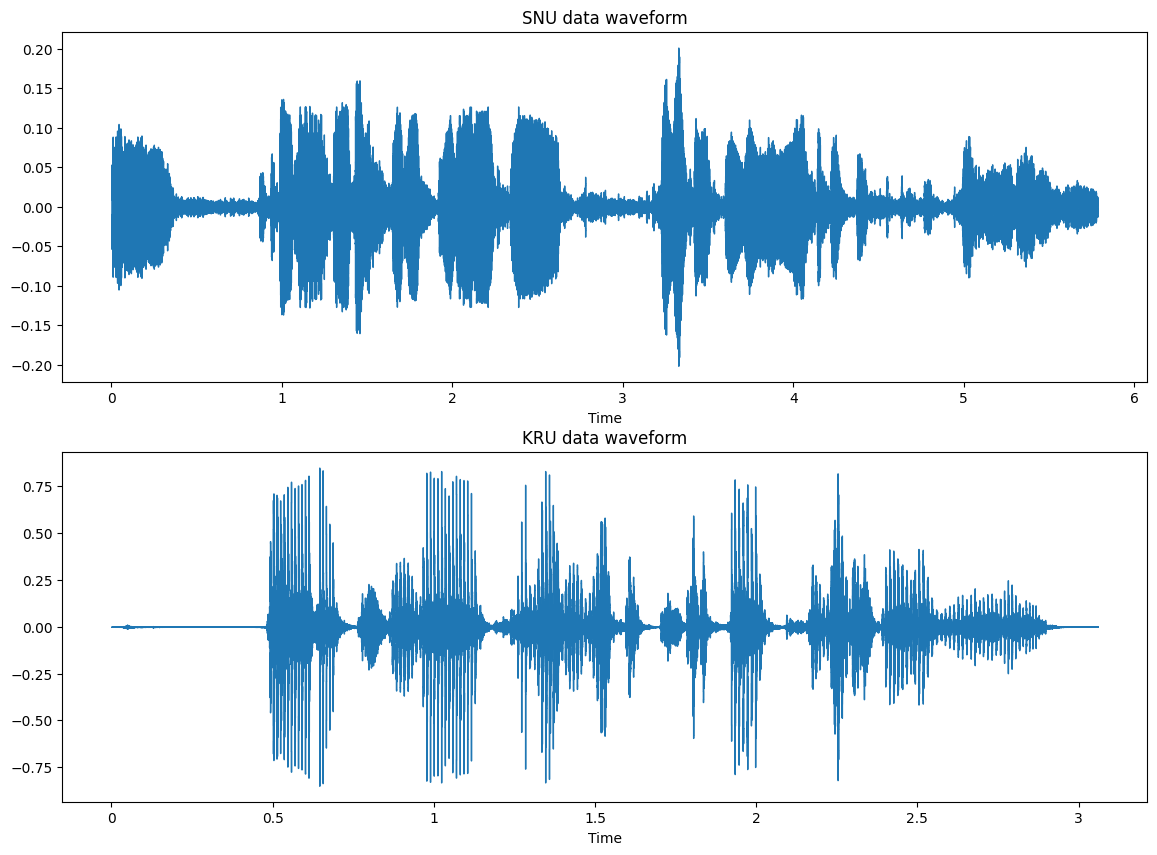

In [7]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 16000 Hz로 맞춰서 로드
SR_TARGET = 16000
snu, sr_snu = librosa.load("/workspace/kor_med_stt_data/snu_data/강지예_201812001_추가적인검사.wav", sr=SR_TARGET)
kru, sr_kru = librosa.load("/workspace/kru_data/원천데이터/의사/HB_0276/HB_0276-1004-01-01-M-04-A.wav", sr=SR_TARGET)

plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
librosa.display.waveshow(snu, sr=SR_TARGET)
plt.title("SNU data waveform")
plt.subplot(2,1,2)
librosa.display.waveshow(kru, sr=SR_TARGET)
plt.title("KRU data waveform")
plt.show()


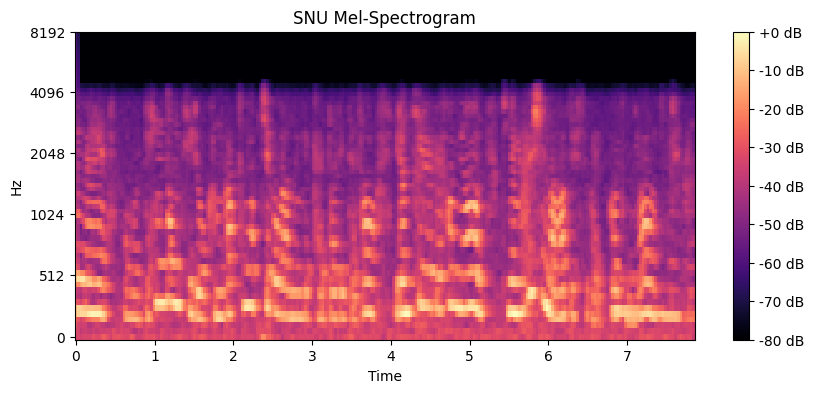

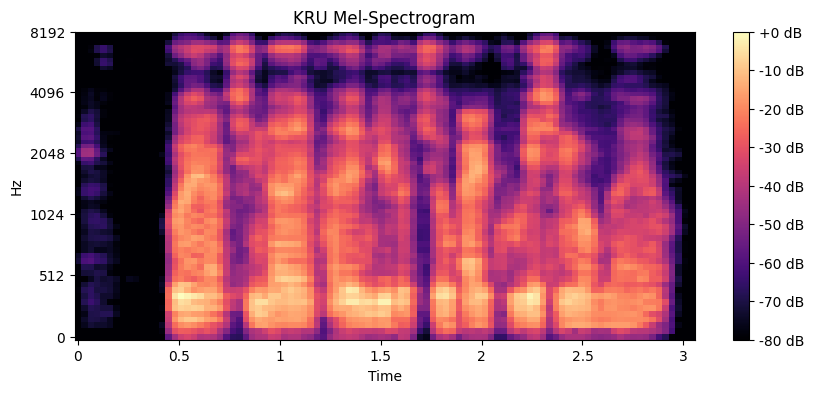

In [6]:
def plot_mel(y, sr, title):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title(title)
    plt.colorbar(format="%+2.0f dB")
    plt.show()

plot_mel(snu, sr_snu, "SNU Mel-Spectrogram")
plot_mel(kru, sr_kru, "KRU Mel-Spectrogram")


In [8]:
mfcc_snu = librosa.feature.mfcc(y=snu, sr=sr_snu, n_mfcc=13)
mfcc_kru = librosa.feature.mfcc(y=kru, sr=sr_kru, n_mfcc=13)

mean_snu, mean_kru = np.mean(mfcc_snu, axis=1), np.mean(mfcc_kru, axis=1)
std_snu, std_kru = np.std(mfcc_snu, axis=1), np.std(mfcc_kru, axis=1)

import pandas as pd
df = pd.DataFrame({"MFCC_mean_SNU": mean_snu, "MFCC_mean_KRU": mean_kru,
                   "MFCC_std_SNU": std_snu, "MFCC_std_KRU": std_kru})
print(df)


    MFCC_mean_SNU  MFCC_mean_KRU  MFCC_std_SNU  MFCC_std_KRU
0     -354.574707    -253.351318     39.950962    170.859131
1      168.869125     103.464027     20.279766     76.063751
2      -44.161858     -31.836912     21.020578     34.889591
3       43.192314      10.865645     17.010939     29.761074
4      -12.201534      -0.865507     11.763259     19.032835
5       -3.614601     -19.466654     12.458793     16.166117
6       19.591139      -4.511335      8.766039     11.860374
7      -19.409725     -14.063313      9.044338     17.647715
8        2.008365     -17.064121      8.701180     12.164845
9      -13.003237      -7.770809      7.915697     15.426113
10      -6.948276     -28.190332      6.209214     17.359863
11       9.370918       0.202568      5.733365      8.766255
12     -11.258147     -27.480438      5.233824     14.985331


In [8]:
import librosa
import numpy as np

import librosa
import numpy as np

# def estimate_snr(y, sr, frame_length=2048, hop_length=512):
#     # RMS energy (frame 단위)
#     energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
#     threshold = np.percentile(energy, 20)  # 하위 20%를 잡음으로 간주
    
#     # 프레임 인덱스를 sample 인덱스로 변환
#     frame_starts = np.arange(len(energy)) * hop_length
#     frame_mask = energy >= threshold  # 신호 프레임
    
#     # 프레임 마스크 → sample 단위 마스크
#     sample_mask = np.zeros_like(y, dtype=bool)
#     for i, start in enumerate(frame_starts):
#         end = min(start + frame_length, len(y))
#         sample_mask[start:end] = frame_mask[i]
    
#     # signal / noise 분리
#     signal = y[sample_mask]
#     noise = y[~sample_mask]
    
#     # 안전 장치
#     if len(noise) < 1 or len(signal) < 1:
#         return np.nan

#     snr = 10 * np.log10(np.mean(signal**2) / np.mean(noise**2))
#     return snr

def estimate_snr_simple(y, sr):
    rms = librosa.feature.rms(y=y)[0]
    noise_floor = np.percentile(rms, 20)
    snr = 10 * np.log10(np.mean(rms**2) / (noise_floor**2 + 1e-8))
    return snr

import librosa

# 파일 로드
snu, sr_snu = librosa.load("/workspace/kor_med_stt_data/snu_data/강지예_201812001_추가적인검사.wav", sr=None)
kru, sr_kru = librosa.load("/workspace/kru_data/원천데이터/의사/HB_0276/HB_0276-1004-01-01-M-04-A.wav", sr=None)

# SNR 계산
snr_snu = estimate_snr_simple(snu, sr_snu)
snr_kru = estimate_snr_simple(kru, sr_kru)

print(f"SNU 데이터 SNR: {snr_snu:.2f} dB")
print(f"KRU 데이터 SNR: {snr_kru:.2f} dB")


SNU 데이터 SNR: 13.54 dB
KRU 데이터 SNR: 28.01 dB
